# 2. SORU – İlerletilmiş Kalman Filtresi

İlerletilmiş Kalman Filtresi, normal Kalman filtresinin non-lineer sistemler için özel bir hâlidir. Elimizdeki gürültülü olan verileri kullanarak real-time tahminleme yapar. Apollo 11’in motor iç ısısını ölçmek en bilindik örneklerden birisidir. Motorun içine doğrudan termometre koyamıyoruz, çünkü 5000 F’dan sonar sensör eriyor. Bunun yerine yakıt giriş debimetresi sensörünü ve motorun dış sıcaklığından gelen veriyi kullanarak tahminleme oluşturmuşlar. Sistem gürültülü, çünkü atmosferden dışarı çıktıkça içerdeki sıcaklık ile dışardaki sıcaklık fark gösterebiliyor, yani dış etkene bağlılık söz konusu. Projenin detayı ve algoritması [Github](https://github.com/mucahitkayadan/Error-State-Extended-Kalman-Filter/blob/master/README.md) linkinde mevcut.

## 2.1. Lidar-and-Radar-sensor-fusion-with-Extended-Kalman-Filter - Matlab

[Sensör Füzyonu](https://www.automotive-iq.com/autonomous-drive/articles/sensor-fusion-technical-challenges-for-level-4-5-self-driving-vehicles), birden çok sensörün bir araya gelip ortaklaşa veri sağladığı sistemdir. Bu projede gnss, imu ve lidar sensörlerinden veri kullanılmıştır. [GitHub](https://github.com/mucahitkayadan/Error-State-Extended-Kalman-Filter)  hesabıma forkladım.
Anaconda – Python 3.6 kullanılarak çalıştırıldı. kullanılarak çalıştırıldı.

Interaktif olarak çalıştırılabilmesi için, görsel - grafik desteği için ve okunaklılık açısından Jupyter Notebook(ipynb) dosyası olarak düzenledim.

## 2.2.	Kodlar ve Açıklamaları

### 2.2.1. Veri

Aşağıdaki blokta gerekli kütüphaneler eklendi.

In [21]:
import pickle  #pkl uzantılı dosya oluşturmak ve o dosyayı açmak için eklendi.
import sys      #sistem fonksiyonları kütüphanesi
import numpy as np   #Bilimsel hesaplama yapma, dizi ve matris yönetmek için eklendi.
import matplotlib.pyplot as plt                    #Çizim yapmak için kullanacağımız kütüphane
from mpl_toolkits.mplot3d import Axes3D          #3D çizim yapabilmemizi sağlar.

In [22]:
from rotations import Quaternion, skew_symmetric
# rotations.py dosyasından sınıfları çeker.

Aşağıdaki bloklarda verilerin olduğu yolu ekleme, veri dosyasını açma gibi sistemsel işlemler yapılır.

In [23]:
sys.path.append('./data')
# verilerin olduğu /data dosyasını dizine ekler.

In [24]:
with open('data/p1_data.pkl', 'rb') as file:
    data = pickle.load(file)
#p1_data.pkl dosyasını çağırıp data adlı değişkene atar.

Aşağıdaki bloklarda, veritabanından aldığımız verileri - parametreleri, değişkenlere atadık.

In [25]:
gt = data['gt']         #ground truth verilerini atar.
imu_f = data['imu_f']   #Special Force olarak Inertial Measurement Unit verilerini atar.
imu_w = data['imu_w']   #Açısal hız olarak Inertial Measurement Unit verilerini atar.
gnss = data['gnss']     #Global Navigation Satellite System verilerini atar.
lidar = data['lidar']   #Lidar verilerini atar.

Aşağıdaki blok, 3D olarak ground truth veriyi çizer.

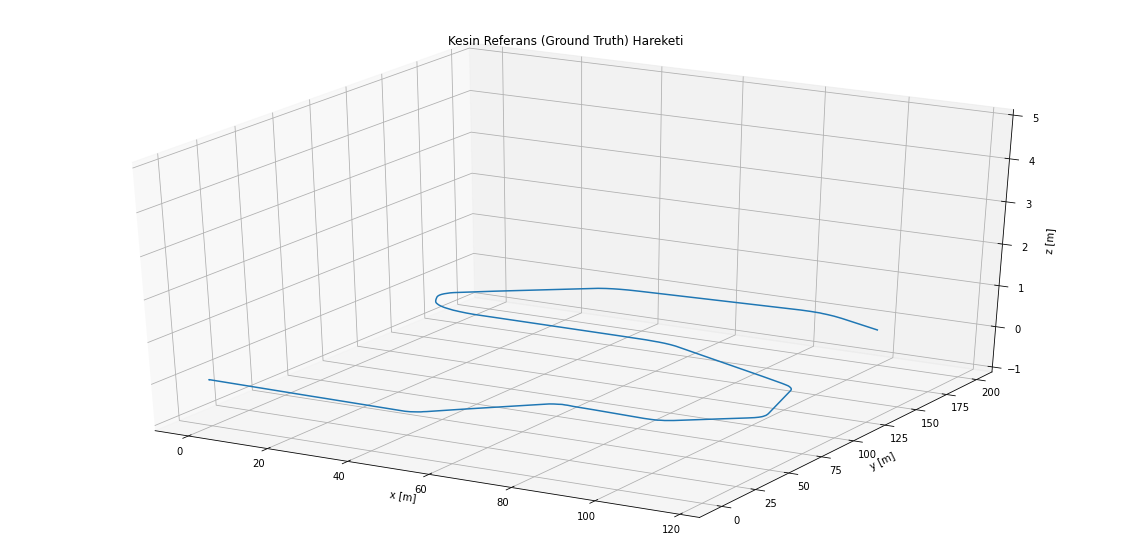

In [26]:
gt_fig = plt.figure(figsize=(20,10)) # grafiği oluşturduk ve boyutunu ayarladık. 
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]') # x eksenini adlandırır.
ax.set_ylabel('y [m]') # y eksenini adlandırır.
ax.set_zlabel('z [m]') # z eksenini adlandırır.
ax.set_title('Kesin Referans (Ground Truth) Hareketi') #Başlık ayarlandı
ax.set_zlim(-1, 5) # z ekseninin limiti -1, 5 aralığında ayarlandı.
plt.show() #grafiği çizer

Lidar verilerini IMU verileri ile örtüştürmek için harici kalibrasyon rotasyon matrisi ve çeviri matrisi kullanıyoruz.

In [27]:
C_li = np.array([
    [ 0.99376, -0.09722,  0.05466],
    [ 0.09971,  0.99401, -0.04475],        #3D rotasyon matrisi
    [-0.04998,  0.04992,  0.9975 ]
])

t_li_i = np.array([0.5, 0.1, 0.5])      # Çeviri matrisi

lidar.data = (C_li @ lidar.data.T).T + t_li_i # @ matris çarpımıdır. .T ise transpozunu verir.

### 2.2.2. Sabitler 

Aşağıdaki kod bloğunda başlangıç parametreleri ayarlanmıştır.

In [28]:
var_imu_f = 0.01
var_imu_w = 0.01
var_gnss = 0.1
var_lidar = 35
gravity = 9.81

In [29]:
g = np.array([0, 0, -gravity])  # Sadece dikey eksene, yani z eksenine negatif yer çekimi uygulanıyor.
l_jac = np.zeros([9, 6]) #Jacobian için 9*6 sıfır matrisi oluşturulur.
l_jac[3:, :] = np.eye(6)  # Hareket modeline Jacobian gürültü ekler. eye fonksiyonu, 
#diagonalı birlerden ve geri kalanı sıfırlardan oluşan matris oluşturur.
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # Jacobian ölçüm modeli.

### 2.2.3. Başlangıç Değerleri 

Aşağıdaki kod bloğu, parametrelerin başlangıç değerlerini sıfırlarla doldurarak oluşturur.

In [30]:
p_est = np.zeros([imu_f.data.shape[0], 3])  # Pozisyon tahmini
v_est = np.zeros([imu_f.data.shape[0], 3])  # Hız tahmini
q_est = np.zeros([imu_f.data.shape[0], 4])  # Kuaterniyon(Euler şeklinde, imajiner) olarak dönüş tahmini
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # Her zaman aralığındaki kovaryans matrisi

Aşağıdaki kod bloğunda, tahmin parametrelerinin ilk elemanları ground trouth parametrelerinin ilk elemanları olarak ayarlanmıştır. 

In [31]:
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.eye(9)  # Tahminin kovaryansı

Kalman filtresi temel olarak iki aşamadan oluşur: **Tahmin et** ve **Güncelle**. Yukarıdaki kod bloğunda tahminin ilk aşaması gerçekleştirilirken, aşağıdaki kod bloğunda ise güncelleme için fonksiyon yazılmıştır.

In [32]:
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    # 3.1 Kalman kazancı hesaplanır
    R_cov = sensor_var * np.eye(3) #kovaryans matrisi için sadece ortogonal eksen alınır.
    K = p_cov_check.dot(h_jac.T.dot(np.linalg.inv(h_jac.dot(p_cov_check.dot(h_jac.T)) + R_cov)))

    # 3.2 Hata durum hesaplaması
    delta_x = K.dot(y_k - p_check)

    # 3.3 Tahmin edilen durumu doğrulama
    p_check = p_check + delta_x[:3]
    v_check = v_check + delta_x[3:6]
    q_check = Quaternion(axis_angle = delta_x[6:]).quat_mult(q_check)

    # 3.4 Doğrulan kovaryansı hesaplama
    p_cov_check = (np.eye(9) - K.dot(h_jac)).dot(p_cov_check)

    return p_check, v_check, q_check, p_cov_check


### 2.2.4. Ana Döngü 

In [34]:
for k in range(1, imu_f.data.shape[0]):  # Birden imu_f boyutuna kadar
    delta_t = imu_f.t[k] - imu_f.t[k - 1] #Değişim miktarı

    # 1. IMU girdileri ile nominal durum güncellemesi
    Rotation_Mat = Quaternion(*q_est[k - 1]).to_mat()
    p_est[k] = p_est[k - 1] + delta_t * v_est[k - 1] + 0.5 * (delta_t ** 2) * (Rotation_Mat.dot(imu_f.data[k - 1]) + g)
    v_est[k] = v_est[k - 1] + delta_t * (Rotation_Mat.dot(imu_f.data[k - 1]) - g)
    q_est[k] = Quaternion(euler = delta_t * imu_w.data[k - 1]).quat_mult(q_est[k - 1])

    # 1.1 Hareket modelini doğrusallaştırma ve Jacobian hesaplama
    F = np.eye(9)
    imu = imu_f.data[k - 1].reshape((3, 1))
    F[0:3, 3:6] = delta_t * np.eye(3)
    F[3:6, 6:9] = Rotation_Mat.dot(-skew_symmetric(imu)) * delta_t

    # 2. Belirsizliği yayma
    Q = np.eye(6)
    Q[0:3, 0:3] = var_imu_f * Q[0:3, 0:3]
    Q[3:6, 3:6] = var_imu_w * Q[3:6, 3:6]
    Q = (delta_t ** 2) * Q #İntegrasyon hızlandırma ve pozisyon elde etme
    p_cov[k] = F.dot(p_cov[k - 1]).dot(F.T) + l_jac.dot(Q).dot(l_jac.T)

    # 3. GNSS ve Lidar ölçümlerinin aktifliğini kontrol etme
    #Eğer GNSS verisi ile IMU verisinin farkının mutlak değeri 0,01'den küçükse, değerleri günceller.
    for i in range(len(gnss.t)):
        if abs(gnss.t[i] - imu_f.t[k]) < 0.01:
            p_est[k], v_est[k], q_est[k], p_cov[k] = measurement_update(var_gnss, p_cov[k],
                                                  gnss.data[i], p_est[k], v_est[k], q_est[k])
    for i in range(len(lidar.t)):
        if abs(lidar.t[i] - imu_f.t[k]) < 0.01:
            p_est[k], v_est[k], q_est[k], p_cov[k] = measurement_update(var_lidar, p_cov[k],
                                                    lidar.data[i], p_est[k], v_est[k], q_est[k])
    #Eğer Lidar verisi ile IMU verisinin farkının mutlak değeri 0,01'den küçükse, değerleri günceller. 

### 2.2.5.Sonuç ve Analiz

Aşağıdaki kod bloğunda, tahmin edilen hareket 3D olarak çizdirilip GT ile karşılaştırılır.

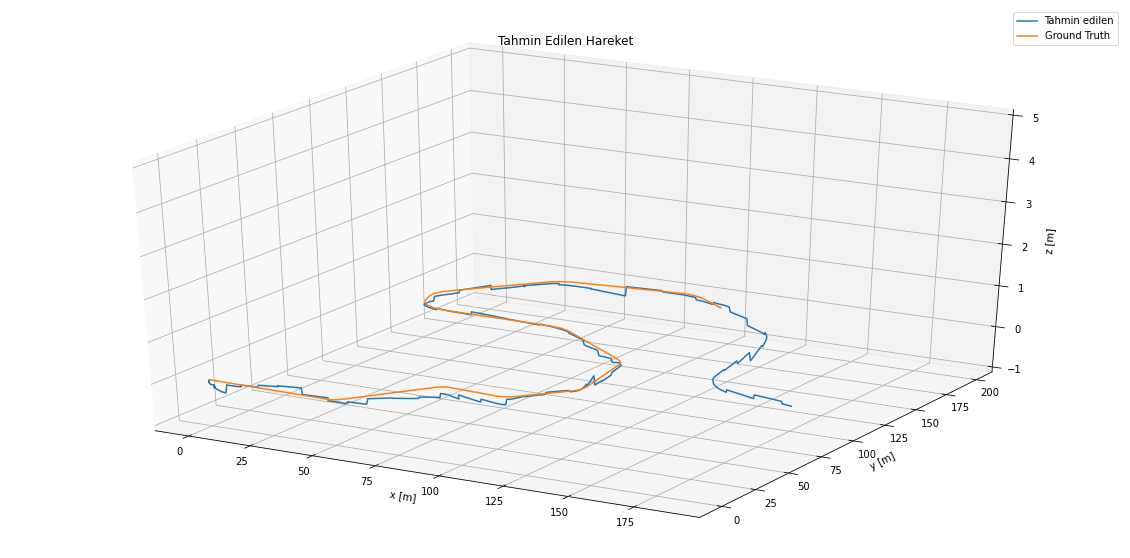

In [35]:
est_traj_fig = plt.figure(figsize=(20,10)) #Figür oluşturulup yeniden boyutlandırıldı
ax = est_traj_fig.add_subplot(111, projection='3d') #2 grafik üst üste bindirildi, görüntü modu 3D.
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Tahmin edilen') #ilk 3 satır, 3 eksen olarak çizdirildi.
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth') #ilk 3 satır, 3 eksen olarak çizdirildi.
ax.set_xlabel('x [m]') #x ekseni yeniden isimlendirildi.
ax.set_ylabel('y [m]') #y ekseni yeniden isimlendirildi.
ax.set_zlabel('z [m]') #z ekseni yeniden isimlendirildi.
ax.set_title('Tahmin Edilen Hareket') #Başlık ayarlandı
ax.legend() #çizim modu: legend
ax.set_zlim(-1, 5) #eksenler -1, 5 arasında sınırlandı
plt.show() #Grafik çizdirildi.

Aşağıdaki kod bloğunda, metre ve radyan cinsinden hatalar çizdirilmiştir. Hataların giderek azaldığı görülmektedir.

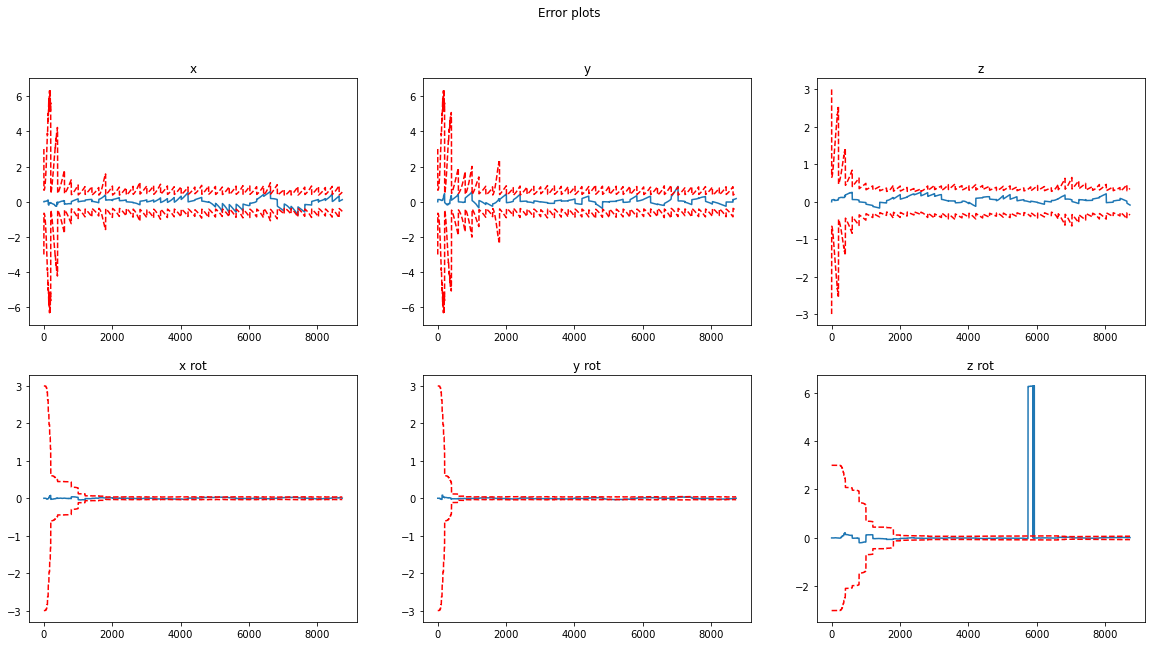

In [36]:
error_fig, ax = plt.subplots(2, 3, figsize=(20,10))
error_fig.suptitle('Error plots')
num_gt = gt.p.shape[0]
p_est_euler = []

for q in q_est:
    p_est_euler.append(Quaternion(*q).to_euler())
p_est_euler = np.array(p_est_euler)

p_cov_diag_std = np.sqrt(np.diagonal(p_cov, axis1=1, axis2=2))

titles = ['x', 'y', 'z', 'x rot', 'y rot', 'z rot']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt), 3 * p_cov_diag_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_diag_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])

for i in range(3):
    ax[1, i].plot(range(num_gt), gt.r[:, i] - p_est_euler[:num_gt, i])
    ax[1, i].plot(range(num_gt), 3 * p_cov_diag_std[:num_gt, i+6], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_diag_std[:num_gt, i+6], 'r--')
    ax[1, i].set_title(titles[i+3])
plt.show()